# Predict the Introverts from the Extroverts

## Imports

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

## About the Data
The data for this competition was generated using a deep learning model trained on the [Extrovert vs. Introvert Behavior dataset](https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data). While the feature distributions closely resemble the original dataset, they are not identical.

The original dataset, provided by Rakesh Kapilavayi, was collected through Google Forms as part of a college research project exploring personality traits and behavioral tendencies among students. Participants answered survey questions using a 0–10 scale, which ensured consistency and simplicity in the responses.
For more details, see the [discussion here](https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/discussion/583203#3218290).

- Competition data: [Playground Series S5E7 Data](https://www.kaggle.com/competitions/playground-series-s5e7/data)
- Original dataset: [Extrovert vs. Introvert Behavior Data](https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data)

I simply concatenated the original and generated datasets for training, as their feature distributions are similar and both are relatively small in size. This method is more suitable than oversampling or weighting because it maximizes the use of all available data without introducing unnecessary complexity or artificial duplication.

In [2]:
# File paths
competition_train_path = "/kaggle/input/playground-series-s5e7/train.csv"
competition_test_path = "/kaggle/input/playground-series-s5e7/test.csv"
original_data_path = "/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv"

# Load datasets
competition_data = pl.read_csv(competition_train_path)
original_data = pl.read_csv(original_data_path)

# Split features (train) and target (test) for both datasets
competition_features = competition_data.select([col for col in competition_data.columns[:-1] if col != "id"])
competition_target = competition_data.select(competition_data.columns[-1])
original_features = original_data.select(original_data.columns[:-1])
original_target = original_data.select(original_data.columns[-1])

# Concatenate both datasets
combined_train = pl.concat([competition_features, original_features], how="vertical")
combined_target = pl.concat([competition_target, original_target], how="vertical")

## EDA
- **Rows:** 21424 (18524 generated, 2900 original)
- **Features:** 7

### Features:
- Time_spent_Alone (numeric, hours per week)
- Stage_fear (categorical, Yes/No)
- Social_event_attendance (numeric, events per month)
- Going_outside (numeric, outings per week)
- Drained_after_socializing (categorical, Yes/No)
- Friends_circle_size (numeric)
- Post_frequency (numeric, posts per week)

### Outliers
No outliers detected using the IQR rule.

### Missing Values
Since the **missing percentage for all columns falls within the moderate range of 5–30%**, the best approach is to **impute missing values** rather than drop rows or columns. 

### Target Variable
**Target Variable Distribution** is imbalanced with significantly more extroverts than introverts.

In [3]:
combined_train.glimpse(max_items_per_column=5)

Rows: 21424
Columns: 7
$ Time_spent_Alone          <f64> 0.0, 1.0, 6.0, 3.0, 1.0
$ Stage_fear                <str> 'No', 'No', 'Yes', 'No', 'No'
$ Social_event_attendance   <f64> 6.0, 7.0, 1.0, 7.0, 4.0
$ Going_outside             <f64> 4.0, 3.0, 0.0, 3.0, 4.0
$ Drained_after_socializing <str> 'No', 'No', None, 'No', 'No'
$ Friends_circle_size       <f64> 15.0, 10.0, 3.0, 11.0, 13.0
$ Post_frequency            <f64> 5.0, 8.0, 0.0, 5.0, None



In [4]:
combined_train.describe()

statistic,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
str,f64,str,f64,f64,str,f64,f64
"""count""",20171.0,"""19458""",20182.0,19892.0,"""20223""",20293.0,20095.0
"""null_count""",1253.0,"""1966""",1242.0,1532.0,"""1201""",1131.0,1329.0
"""mean""",3.330177,null,5.082053,3.895536,null,7.756369,4.782135
"""std""",3.111568,null,2.811595,2.121479,null,4.27468,2.927682
"""min""",0.0,"""No""",0.0,0.0,"""No""",0.0,0.0
"""25%""",1.0,null,3.0,2.0,null,4.0,2.0
"""50%""",2.0,null,5.0,4.0,null,8.0,5.0
"""75%""",5.0,null,7.0,6.0,null,11.0,7.0
"""max""",11.0,"""Yes""",10.0,7.0,"""Yes""",15.0,10.0


In [5]:
def get_numerical_and_categorical_columns(df: pl.DataFrame):
    """
    Returns two lists of column names: (numerical_columns, categorical_columns)
    for the given Polars DataFrame.
    """
    numeric_types = {
        pl.Int8, pl.Int16, pl.Int32, pl.Int64,
        pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
        pl.Float32, pl.Float64
    }
    numerical_cols = [col for col, dtype in df.schema.items() if dtype in numeric_types]
    categorical_cols = [col for col, dtype in df.schema.items() if dtype in {pl.Utf8, pl.Categorical}]
    return numerical_cols, categorical_cols

In [6]:
numerical_cols, categorical_cols = get_numerical_and_categorical_columns(combined_train)
print("Numerical columns:")
print(numerical_cols)
print("Categorical columns:")
print(categorical_cols)

Numerical columns:
['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Categorical columns:
['Stage_fear', 'Drained_after_socializing']


In [7]:
def has_outliers(df: pl.DataFrame, col: str) -> bool:
    q1 = df.select(pl.col(col).quantile(0.25)).item()
    q3 = df.select(pl.col(col).quantile(0.75)).item()
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_count = df.filter((pl.col(col) < lower) | (pl.col(col) > upper)).height
    return outlier_count > 0

In [8]:
print("Contains Outliers:")
for col in numerical_cols:
    print(f"{col}:{has_outliers(combined_train, col)}")

Contains Outliers:
Time_spent_Alone:False
Social_event_attendance:False
Going_outside:False
Friends_circle_size:False
Post_frequency:False


In [9]:
row_count = combined_train.height

# Get missing counts and percentages per column
missing_counts = [
    pl.col(col).is_null().sum().alias("missing_count") for col in combined_train.columns
]
missing_pcts = [
    (pl.col(col).is_null().sum() / row_count * 100).alias("missing_pct") for col in combined_train.columns
]

# Combine into a single DataFrame
summary = pl.DataFrame({
    "Feature": combined_train.columns,
    "missing_count": [combined_train.select(expr).item() for expr in missing_counts],
    "missing_pct": [round(combined_train.select(expr).item(), 2) for expr in missing_pcts]
})

print(summary)

shape: (7, 3)
┌───────────────────────────┬───────────────┬─────────────┐
│ Feature                   ┆ missing_count ┆ missing_pct │
│ ---                       ┆ ---           ┆ ---         │
│ str                       ┆ i64           ┆ f64         │
╞═══════════════════════════╪═══════════════╪═════════════╡
│ Time_spent_Alone          ┆ 1253          ┆ 5.85        │
│ Stage_fear                ┆ 1966          ┆ 9.18        │
│ Social_event_attendance   ┆ 1242          ┆ 5.8         │
│ Going_outside             ┆ 1532          ┆ 7.15        │
│ Drained_after_socializing ┆ 1201          ┆ 5.61        │
│ Friends_circle_size       ┆ 1131          ┆ 5.28        │
│ Post_frequency            ┆ 1329          ┆ 6.2         │
└───────────────────────────┴───────────────┴─────────────┘


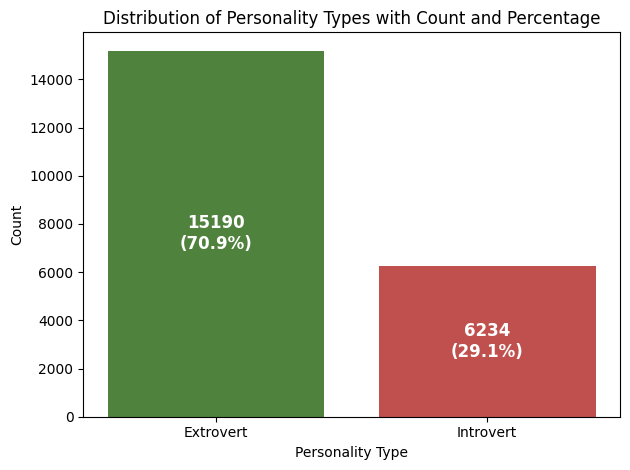

In [10]:
vc = (
    combined_target.group_by("Personality")
      .len()
      .with_columns(
          (pl.col("len") / pl.col("len").sum() * 100).alias("pct")
      )
      .sort("len", descending=True)
)

labels = vc["Personality"].to_list()
counts = vc["len"].to_list()
pcts = vc["pct"].to_list()

bars = plt.bar(labels, counts, color=["#4f823d", "#c0504d"])
for bar, c, p in zip(bars, counts, pcts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,   
        height / 2,                           
        f"{c}\n({p:.1f}%)",
        ha="center", va="center",
        fontsize=12, color='white', fontweight='bold'
    )
plt.xlabel("Personality Type")
plt.ylabel("Count")
plt.title("Distribution of Personality Types with Count and Percentage")
plt.tight_layout()
plt.show()

## Train Test Split

I will employ **stratified k-fold cross-validation** because our **dataset has class imbalance**, and this method ensures that each fold maintains the same class proportions as the overall dataset, providing a more reliable and unbiased estimate of model performance. Cross-validation in general is valuable because it allows us to assess how well a **model will generalize to unseen data**, helps prevent overfitting, and provides a more accurate and robust evaluation than a single train-test split

## Pre-processing

### Feature Selection
With only 7 features, **feature selection is not necessary**.

### Missing Values
For numeric columns, we will use the median or mean to fill in missing values, while for categorical columns, we will use the mode. This strategy **preserves the size and integrity of our dataset**, ensuring we do not lose valuable information due to moderate missingness.

### Normalization
Since the **numeric columns do not have outliers**, **Min-Max normalization** is a suitable choice. It scales features to a fixed range, typically , preserving the original distribution shape and making features comparable.

### Encoding
I used encoding techniques such as **label encoding** to transform categorical variables (Stage_fear, Drained_after_socializing) into numeric values, making them suitable for machine learning algorithms that require numerical input. 

### Transformation
All transformations are fit exclusively on X_train; otherwise, if each set computes its own imputation, scaling, or encoding, information from X_test can leak into the transformation process.

In [11]:
# Load datasets
competition_data = pd.read_csv(competition_train_path)
original_data = pd.read_csv(original_data_path)

# Split features and target for both datasets
competition_features = competition_data.drop(columns=[competition_data.columns[-1], "id"])
competition_target = competition_data[[competition_data.columns[-1]]]
original_features = original_data.drop(columns=[original_data.columns[-1]])
original_target = original_data[[original_data.columns[-1]]]

# Concatenate features and targets vertically
combined_train_pd = pd.concat([competition_features, original_features], axis=0, ignore_index=True)
combined_target_pd = pd.concat([competition_target, original_target], axis=0, ignore_index=True)

In [12]:
# Preprocessing pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder()) 
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

target_transformer = Pipeline([
    ('encoder', OrdinalEncoder())
])

## Modeling
This is a supervised binary classification problem, so I will start with models suited for tabular binary classification:
- Logistic Regression
- Random Forest Classifier
- Gradient Boosting Machines (e.g., XGBoost, LightGBM, CatBoost)
- Support Vector Machine (SVM)
- Neural Networks (MLPClassifier for tabular data)
  
Since LightGBM achieved the highest performance, I selected it for further hyperparameter tuning.

### Tuning
Hyperparameter tuning directly impacts a model’s structure, learning process, and final performance, allowing me to optimize accuracy, generalization, and training efficiency. I chose Bayesian optimization because it reduces the number of evaluations needed to find strong hyperparameter settings, saving both time and computational resources.

In [13]:
def run_model(model, X_train, y_train, X_test, y_test):
    """
    Fits the model, makes predictions, and returns accuracy.
    """
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return {
        'preds': preds,
        'accuracy': accuracy_score(y_test, preds),
    }

In [14]:
RANDOM_STATE = 42
MODEL_SELECTED = True

if MODEL_SELECTED == False: 
    # Stratified K-Fold with pipeline
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    X = combined_train_pd
    y = combined_target_pd
    
    results = {
        'LogisticRegression': [],
        'RandomForest': [],
        'XGBoost': [],
        'LightGBM': [],
        'CatBoost': [],
        'SVM': [],
        'MLPClassifier': []
    }
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit only on training data, transform all
        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)
        y_train = target_transformer.fit_transform(y_train)
        y_test = target_transformer.transform(y_test)
    
        # Fix target shape
        y_train = y_train.ravel()
        y_test = y_test.ravel()
    
        # Logistic Regression
        lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
        results['LogisticRegression'].append(
            run_model(lr, X_train, y_train, X_test, y_test)
        )
    
        # Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
        results['RandomForest'].append(
            run_model(rf, X_train, y_train, X_test, y_test)
        )
    
        # XGBoost
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
        results['XGBoost'].append(
            run_model(xgb, X_train, y_train, X_test, y_test)
        )
    
        # LightGBM
        lgbm = LGBMClassifier(random_state=RANDOM_STATE)
        results['LightGBM'].append(
            run_model(lgbm, X_train, y_train, X_test, y_test)
        )
    
        # CatBoost
        catboost = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)
        results['CatBoost'].append(
            run_model(catboost, X_train, y_train, X_test, y_test)
        )
    
        # SVM (Support Vector Machine)
        svm = SVC(probability=True, random_state=RANDOM_STATE)
        results['SVM'].append(
            run_model(svm, X_train, y_train, X_test, y_test)
        )
    
        # MLPClassifier (Neural Network)
        mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=RANDOM_STATE)
        results['MLPClassifier'].append(
            run_model(mlp, X_train, y_train, X_test, y_test)
        )
    
clear_output()

In [15]:
if MODEL_SELECTED == False: 
    average_accuracies = {
        model: sum(fold['accuracy'] for fold in folds) / len(folds)
        for model, folds in results.items()
    }
    sorted_models = sorted(average_accuracies.items(), key=lambda x: x[1], reverse=True)
    sorted_models

In [16]:
X_for_tuning = preprocessor.fit_transform(combined_train_pd)
y_for_tuning = target_transformer.fit_transform(combined_target_pd)

def objective_lgbm(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': RANDOM_STATE
    }
    model = LGBMClassifier(**params)
    # Use cross-validation to evaluate
    score = cross_val_score(model, X_for_tuning, y_for_tuning, cv=5, scoring='accuracy').mean()
    return score

# Objective function for CatBoost
def objective_catboost(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'iterations': trial.suggest_int('iterations', 100, 500),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_seed': RANDOM_STATE,
        'verbose': False
    }
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_for_tuning, y_for_tuning, cv=5, scoring='accuracy').mean()
    return score

# Objective function for XGBoost
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': RANDOM_STATE,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_for_tuning, y_for_tuning, cv=5, scoring='accuracy').mean()
    return score


#study_catboost = optuna.create_study(direction='maximize')
#study_catboost.optimize(objective_catboost, n_trials=50)
#study_xgb = optuna.create_study(direction='maximize')
#study_xgb.optimize(objective_xgb, n_trials=50)
#study_lgbm = optuna.create_study(direction='maximize')
#study_lgbm.optimize(objective_lgbm, n_trials=50)
clear_output()

In [17]:
#print("Best parameters:", study_xgb.best_params)
#print("Best parameters:", study_catboost.best_params)
#print("Best parameters:", study_lgbm.best_params)

In [18]:
xgb_params = {
    'max_depth': 6, 
    'learning_rate': 0.002662020358149838, 
    'n_estimators': 461, 
    'min_child_weight': 3, 
    'subsample': 0.7850817328023146, 
    'colsample_bytree': 0.8460871042337839
}
catboost_params = {
    'depth': 5, 
    'learning_rate': 0.009296752469799859, 
    'iterations': 278, 
    'l2_leaf_reg': 0.013669387846498373, 
    'border_count': 240
}
lgbm_params = {
    'num_leaves': 63, 
    'max_depth': 5, 
    'learning_rate': 0.00573052179759354, 
    'n_estimators': 200, 
    'min_child_samples': 16, 
    'subsample': 0.7254193460077228, 
    'colsample_bytree': 0.7337516410826076
}
lgbm = LGBMClassifier(**lgbm_params, random_state=RANDOM_STATE)
catboost = CatBoostClassifier(**catboost_params, random_state=RANDOM_STATE, verbose=0)
xgb = XGBClassifier(**xgb_params, random_state=RANDOM_STATE)

ensemble = VotingClassifier(
    estimators=[
        ('lgbm', lgbm),
        ('catboost', catboost),
        ('xgb', xgb)
    ],
    voting='soft' 
)
FINAL_MODEL = ensemble

# Submission

In [19]:
test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
test = test.drop(columns=["id"])

X = preprocessor.fit_transform(combined_train_pd)
y = target_transformer.fit_transform(combined_target_pd).ravel()
test = preprocessor.transform(test)
FINAL_MODEL.fit(X, y)
preds = FINAL_MODEL.predict(test)
clear_output()

In [20]:
preds = preds.astype(int)
label_map = np.array(["Extrovert", "Introvert"])
preds_labels = label_map[preds]
submission = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")
submission["Personality"] = preds_labels
submission.to_csv("submission.csv", index=False)
submission.head()

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
